In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import numpy as np
import pandas as pd
import os

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [62]:
temperatures=pd.read_csv('/content/drive/MyDrive/Deep learning/GlobalTemperatures.csv')
temperatures

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063


In [63]:
ts=temperatures[['dt','LandAverageTemperature']]
ts['dt']=pd.to_datetime(ts['dt'])
ts.index=ts['dt']
ts=ts.drop('dt',axis=1)
ts

,LandAverageTemperature
dt,
1750-01-01,3.034
1750-02-01,3.083
1750-03-01,5.626
1750-04-01,8.490
1750-05-01,11.573
...,...
2015-08-01,14.755
2015-09-01,12.999
2015-10-01,10.801


In [64]:
ts=ts['LandAverageTemperature'].interpolate(method='linear')
ts

dt
1750-01-01     3.034
1750-02-01     3.083
1750-03-01     5.626
1750-04-01     8.490
1750-05-01    11.573
               ...  
2015-08-01    14.755
2015-09-01    12.999
2015-10-01    10.801
2015-11-01     7.433
2015-12-01     5.518
Name: LandAverageTemperature, Length: 3192, dtype: float64

In [65]:
ts_resample=ts.resample('A').mean()
ts_resample

dt
1750-12-31    8.373542
1751-12-31    8.102417
1752-12-31    6.501333
1753-12-31    8.388083
1754-12-31    8.469333
                ...   
2011-12-31    9.516000
2012-12-31    9.507333
2013-12-31    9.606500
2014-12-31    9.570667
2015-12-31    9.831000
Freq: A-DEC, Name: LandAverageTemperature, Length: 266, dtype: float64

<Axes: xlabel='dt'>

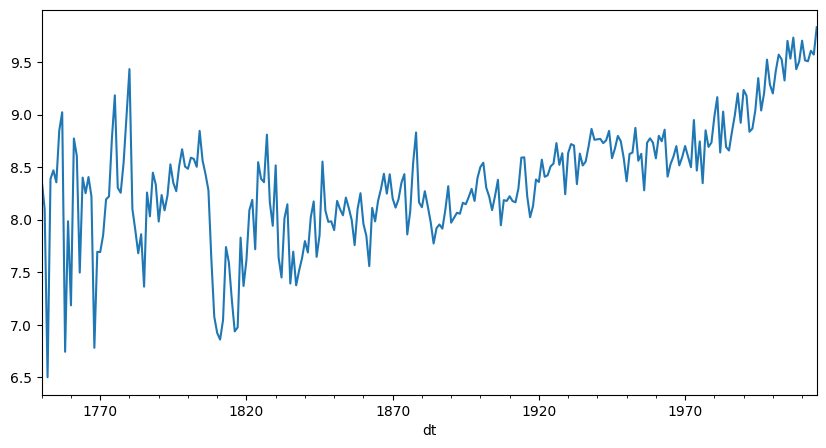

In [66]:
ts_resample.plot()

In [67]:
from statsmodels.tsa.stattools import adfuller

adf_result=adfuller(ts_resample,autolag='AIC')

#check the value of p_value and statistics
print("p-value:",adf_result[1])
print("ADF statistics:",adf_result[0])

p-value: 0.8003592633933072
ADF statistics: -0.8615865298179498


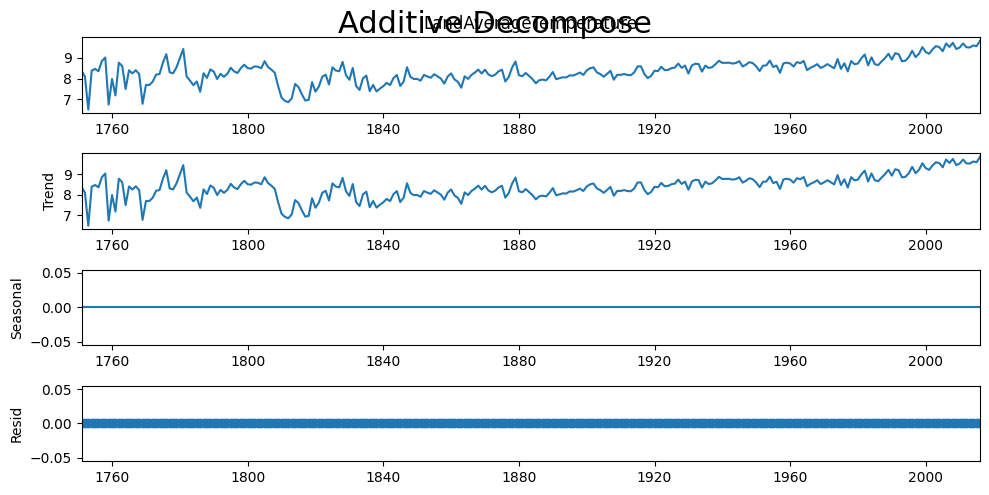

In [68]:
result=sm.tsa.seasonal_decompose(x=ts_resample, model='additive', extrapolate_trend='freq')
plt.rcParams.update({'figure.figsize':(10,5)})
result.plot().suptitle('Additive Decompose',fontsize=22)
plt.show()

In [69]:
train_length=int(len(ts_resample)*0.9)

train=ts_resample[: train_length]
test=ts_resample[train_length :]
train.shape, test.shape

((239,), (27,))

In [70]:
y_train=train.values
y_test=test.values

In [71]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

#fit model
model = ARIMA(y_train, order=(0,2,1)).fit()
model.aic

271.81282205976487

In [72]:
#Make the predicions
y_hat=model.predict(len(train),len(train)+len(test)-1)

In [73]:
test=pd.DataFrame(test)
y_hat=pd.DataFrame(y_hat)

In [74]:
MSE=np.square(np.subtract(test, y_hat)).mean()
print("MSE",MSE)

RMSE=np.sqrt(MSE)
print("RMSE",RMSE)

MSE LandAverageTemperature    0.075573
dtype: float64
RMSE LandAverageTemperature    0.274905
dtype: float64
